In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install torch torchvision numpy matplotlib pycocotools

In [ ]:
import torchvision

In [ ]:
import numpy as np
from torchvision.transforms import functional as F
import torch
from torchvision.transforms import Normalize

#Load Data

In [ ]:
def load_npy_image(npy_path):
    data = np.load(npy_path)  # Load .npy file
    rgb = data[..., :3]  # Extract RGB channels
    rgb_tensor = torch.from_numpy(rgb).permute(2, 0, 1).float() / 255.0  # Convert to float and scale
    rgb_tensor = imagenet_normalize(rgb_tensor)  # Normalize using ImageNet stats
    return rgb_tensor

In [ ]:
import os
import json
import torch
from torch.utils.data import Dataset
from PIL import Image
from pycocotools import mask as coco_mask
import numpy as np

class ThermalBridgeDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)

        self.images = {img['id']: img['file_name'] for img in self.coco_data['images']}
        '''self.annotations = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            self.annotations.setdefault(img_id, []).append(ann)'''

        self.annotations = {}
        for ann in self.coco_data['annotations']:
            #print(ann)
            img_id = ann['image_id']
            #print(img_id)
            if img_id not in self.annotations:
                self.annotations[img_id] = []
            self.annotations[img_id].append(ann)

        self.valid_images = []
        for img_id, file_name in self.images.items():
            img_path = os.path.join(self.root_dir, file_name)
            if os.path.exists(img_path):
                self.valid_images.append((img_id, img_path))
            else:
                print(f"Skipping missing file: {img_path}")

    def __len__(self):
        return len(self.valid_images)

    def __getitem__(self, idx):
        img_id, img_path = self.valid_images[idx]
        image = load_npy_image(img_path)  # You mentioned this in your original code

        boxes = []
        labels = []
        masks = []

        for ann in self.annotations[img_id]:
            # Bounding box
            x_min, y_min, width, height = ann['bbox']
            x_max, y_max = x_min + width, y_min + height
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(1)  # Thermal bridge = class 1

            # Segmentation mask
            segmentation = ann.get('segmentation')
            if segmentation is not None:
                if isinstance(segmentation, list):
                    # Polygon
                    rles = coco_mask.frPyObjects(segmentation, image.shape[1], image.shape[2])
                    rle = coco_mask.merge(rles)
                else:
                    # RLE directly
                    rle = segmentation

                binary_mask = coco_mask.decode(rle)
                if binary_mask.ndim == 3:
                    binary_mask = binary_mask[:, :, 0]  # take first channel
                masks.append(torch.tensor(binary_mask, dtype=torch.uint8))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.stack(masks, dim=0) if masks else torch.zeros((0, image.shape[1], image.shape[2]), dtype=torch.uint8)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks

        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


#Training

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights

# Load pretrained weights
weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = maskrcnn_resnet50_fpn_v2(weights=weights)

# Modify the heads for your custom dataset (2 classes = 1 object class + background)
num_classes = 2

# Replace box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Replace mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    in_features_mask, hidden_layer, num_classes
)


In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Paths
train_images_dir = "/content/drive/MyDrive/TBBR/train/images/"
train_annotations_file = "/content/drive/MyDrive/TBBR/train/Flug1_100-104Media_coco.json"
#test_images_dir = "test/images/"
#test_annotations_file = "test/Flug1_105Media_coco.json"

# Create dataset and dataloaders
train_dataset = ThermalBridgeDataset(train_images_dir, train_annotations_file)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Define optimizer
#optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)



# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

num_epochs = 50 #change parameter here

all_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    steps = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        steps += 1

    avg_loss = epoch_loss / steps
    all_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}, Avg Loss: {avg_loss:.4f}")
    scheduler.step()


plt.plot(range(1, num_epochs + 1), all_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Over Epochs")
plt.grid(True)
plt.show()

#Testing and Prediction

In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
torch.save(model.state_dict(), "thermal_bridge_maskedrcnn_v2_50_normalization.pth")

In [ ]:



test_images_dir = "/content/drive/MyDrive/TBBR/test/images/"
test_annotations_file = "/content/drive/MyDrive/TBBR/test/Flug1_105Media_coco.json"

test_dataset = ThermalBridgeDataset(test_images_dir, test_annotations_file)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))



In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
#model = fasterrcnn_resnet50_fpn(pretrained=True)
model.load_state_dict(torch.load("/content/drive/MyDrive/Thermal bridge models/thermal_bridge_maskedrcnn_v2_50_normalization.pth"))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()


In [ ]:
#predict for induvidual image

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()


# Choose index of the image in your dataset
index = 15 # Change this to test other images

# Get image (no need for the target during inference)
image, _ = test_dataset[index]  # Assuming your dataset object is named `test_dataset`

# Add batch dimension and move to device
image_tensor = image.unsqueeze(0).to(device)

# Run inference
with torch.no_grad():
    output = model(image_tensor)[0]


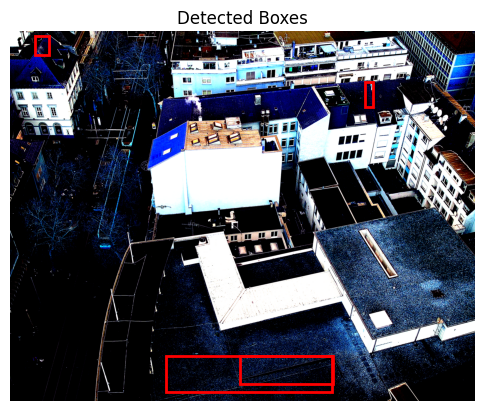

In [ ]:
import matplotlib.pyplot as plt

# Convert tensor to NumPy array for display
img_np = image.permute(1, 2, 0).cpu().numpy()

plt.imshow(img_np, cmap='gray')  # Use 'gray' if single-channel

# Draw bounding boxes
for box in output['boxes'].cpu().numpy():
    x1, y1, x2, y2 = box.astype(int)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                      fill=False, edgecolor='red', linewidth=2))

plt.title("Detected Boxes")
plt.axis("off")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.patches as patches

def display_comparison(model, dataset, index, device, score_threshold=0.5):
    model.eval()

    # Load image and ground truth
    image, target = dataset[index]
    image_tensor = image.unsqueeze(0).to(device)
    target = {k: v.to(device) for k, v in target.items()}

    # Run inference
    with torch.no_grad():
        output = model(image_tensor)[0]

    # Convert image to NumPy
    img_np = image.permute(1, 2, 0).cpu().numpy()

    # Prepare figure
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Original Image
    axs[0].imshow(img_np, cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    # 2. Ground Truth
    axs[1].imshow(img_np, cmap='gray')
    for box in target['boxes'].cpu().numpy():
        x1, y1, x2, y2 = box.astype(int)
        axs[1].add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                           linewidth=2, edgecolor='green', facecolor='none'))
    for mask in target['masks'].cpu().numpy():
        axs[1].imshow(np.ma.masked_where(mask == 0, mask), alpha=0.5, cmap='Greens')
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    # 3. Predictions
    axs[2].imshow(img_np, cmap='gray')
    for box, score in zip(output['boxes'].cpu().numpy(), output['scores'].cpu().numpy()):
        if score >= score_threshold:
            x1, y1, x2, y2 = box.astype(int)
            axs[2].add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                               linewidth=2, edgecolor='red', facecolor='none'))
            axs[2].text(x1, y1 - 5, f"{score:.2f}", color='red', fontsize=8)
    for i, mask in enumerate(output['masks'].cpu().numpy()):
        if output['scores'][i] >= score_threshold:
            axs[2].imshow(np.ma.masked_where(mask[0] < 0.5, mask[0]), alpha=0.5, cmap='Reds')
    axs[2].set_title("Predictions")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
# Assume model and dataset are ready
display_comparison(model, test_dataset, index=67, device=device, score_threshold=0.1)


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.patches as patches

def display_overlay(model, dataset, index, device, score_threshold=0.5):
    model.eval()

    # Load image and ground truth
    image, target = dataset[index]
    image_tensor = image.unsqueeze(0).to(device)
    target = {k: v.to(device) for k, v in target.items()}

    # Run inference
    with torch.no_grad():
        output = model(image_tensor)[0]

    # Convert image to NumPy
    img_np = image.permute(1, 2, 0).cpu().numpy()

    # Prepare figure
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    ax = plt.gca()

    # Plot ground truth boxes and masks in green
    for box in target['boxes'].cpu().numpy():
        x1, y1, x2, y2 = box.astype(int)
        ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       linewidth=2, edgecolor='green', facecolor='none'))
    for mask in target['masks'].cpu().numpy():
        plt.imshow(np.ma.masked_where(mask == 0, mask), alpha=0.3, cmap='Greens')

    # Plot predicted boxes and masks in red
    for box, score in zip(output['boxes'].cpu().numpy(), output['scores'].cpu().numpy()):
        if score >= score_threshold:
            x1, y1, x2, y2 = box.astype(int)
            ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                           linewidth=2, edgecolor='red', facecolor='none'))
            ax.text(x1, y1 - 5, f"{score:.2f}", color='red', fontsize=8)
    for i, mask in enumerate(output['masks'].cpu().numpy()):
        if output['scores'][i] >= score_threshold:
            plt.imshow(np.ma.masked_where(mask[0] < 0.5, mask[0]), alpha=0.3, cmap='Reds')

    plt.title("Overlay: Ground Truth (Green) vs Predictions (Red)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
display_overlay(model, test_dataset, index=25, device=device, score_threshold=0.1)

In [ ]:
from torchvision.ops import box_iou
import numpy as np
import torch

def evaluate_model(model, dataset, device, iou_threshold=0.5, score_threshold=0.4):
    model.eval()
    aps, all_precisions, all_recalls, all_accuracies = [], [], [], []

    for i in range(len(dataset)):
        image, target = dataset[i]
        image_tensor = image.to(device).unsqueeze(0)
        target = {k: v.to(device) for k, v in target.items()}

        with torch.no_grad():
            output = model(image_tensor)[0]

        pred_boxes = output['boxes'][output['scores'] > score_threshold]
        gt_boxes = target['boxes']

        # If no predictions or GTs
        if len(pred_boxes) == 0 and len(gt_boxes) == 0:
            precision = recall = accuracy = ap = 1.0
            tp = fp = fn = 0
        elif len(pred_boxes) == 0:
            tp = 0
            fp = 0
            fn = len(gt_boxes)
            precision = recall = accuracy = ap = 0.0
        elif len(gt_boxes) == 0:
            tp = 0
            fp = len(pred_boxes)
            fn = 0
            precision = recall = accuracy = ap = 0.0
        else:
            ious = box_iou(pred_boxes, gt_boxes)
            matched = (ious > iou_threshold).any(dim=1).cpu().numpy()
            tp = matched.sum()
            fp = len(pred_boxes) - tp
            fn = len(gt_boxes) - tp

            precision = tp / (tp + fp + 1e-6)
            recall = tp / (tp + fn + 1e-6)
            accuracy = tp / (tp + fp + fn + 1e-6)
            ap = precision * recall  # crude AP approximation

        all_precisions.append(precision)
        all_recalls.append(recall)
        all_accuracies.append(accuracy)
        aps.append(ap)



    print("\n==== Overall Metrics ====")
    print(f"Mean Precision: {np.mean(all_precisions):.4f}")
    print(f"Mean Recall:    {np.mean(all_recalls):.4f}")
    print(f"Mean Accuracy:  {np.mean(all_accuracies):.4f}")
    print(f"mAP (approx):   {np.mean(aps):.4f}")


In [ ]:
evaluate_model(model, test_dataset, device=device)